# Final Project

## Live Demo & Game Rules

You start with a grid of hidden cells.

You can choose to click and reveal any cell.

If the cell has a mine, the game (usually) ends.

If the cell is not a mine, it shows a number from 0 to 8. This number tells you how many mines are in the 8 cells next to it.

Your goal is to use these number clues to figure out where the mines are and safely reveal all the cells that are not mines

## Input/Output


Input:

Question to consider: How should you represent the current game board as a tensor that a neural network can understand?

You need to represent different kinds of information on the board, such as: Unrevealed cells; revealed cells with their number clues (0-8); cells you have marked with a flag.


Output:

Question to consider: What should your network output to help the bot make a decision?

Your output can be different depending on the task you choose.

For Task 1: The output could be a probability map. It can show the probability that each unrevealed cell is safe to open.

For Task 2: The output could be a value that predicts the "expected outcome". For example, it could predict how many more moves the bot can safely make after clicking a certain cell.

##  Data Collection

A key challenge in this project is that no dataset is provided. You need to generate your own training data.

Main Method: Use a Logic Bot

The project description gives you the full algorithm for a basic logic bot.

Main Idea: You can first implement this logic bot, then let it play many games automatically. During this process, you can record the "board state (as your input)" and the "true mine locations (as your label)" for each move. This will create a large dataset for Task 1.

Advanced Method: Actor-Critic for Task 2

For Task 2, data collection is a dynamic process. First, an "Actor" bot plays the game. Then, a "Critic" network learns to predict how well the Actor is performing (e.g., how long it survives).


After the Critic is trained, it can be used to help the Actor make better decisions. This cycle of "Actor improves -> generates new data -> trains the Critic -> guides the Actor" repeats, allowing the bot to improve itself.

## Understanding the Tasks

Task 1: Playing by Mine Prediction


Goal: Train a network that takes the current board state as input and predicts which cells are safe.


Performance Goal: Your network bot must perform as well as or better than the basic logic bot on several metrics (like win rate, average survival steps, etc.).


Important Hint: The project states that a simple CNN model may not be enough to solve the problem, because information in one part of the board can affect decisions far away.


Task 2: Playing by Move Prediction


A New Approach: Instead of predicting mines, the network predicts "what is the expected outcome if I make this move?".

Core Model: Implement an Actor-Critic model.

    Actor: Looks at the board, scores every possible move, and picks the move with the highest score.

    Critic: Learns to accurately predict how well the Actor will do after making a certain move.

Goal: You must show that your Critic can successfully predict the Actor's performance, and that the Actor's performance improves over time as it gets trained.


Task 3: Thinking Deeper


Core Concept: This is a more exploratory task. You need to design a network that can "think longer" about its next move.


How to Implement: Model the decision process as a sequential process. The more steps your network runs (the longer it "thinks"), the better its decision should be.

Related Topics: Sequential models and ResNets might be useful here.

Goal: You must show that the model's prediction loss goes down and its game performance goes up  the longer it "thinks." You will need to visualize this "thinking" process with a heatmap.





I hope this guide helps you get started on your final project!

# Homework 2 Discussion

## Auto-Encoders

Experiment: MLP Autoencoder on MNIST
<br>
Goal: Demonstrate a simple autoencoder, show reconstruction

In [31]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np, time, random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); np.random.seed(0); random.seed(0)

In [32]:
# 1) DATA: Load MNIST Dataset

mnist_tfm = transforms.Compose([transforms.ToTensor()])
mnist_train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=mnist_tfm)
mnist_test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=mnist_tfm)

mnist_train_loader = DataLoader(mnist_train_ds, batch_size=128, shuffle=True, num_workers=2)
mnist_test_loader = DataLoader(mnist_test_ds, batch_size=256, shuffle=False, num_workers=2)

In [33]:
# 2) MODEL: A simple MLP-based Autoencoder

class MLPAutoEncoder(nn.Module):
    def __init__(self, bottleneck_k=32):
        super().__init__()
        # Encoder maps 784 -> hidden_dim -> k
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256), # The first hidden layer
            nn.ReLU(),
            nn.Linear(256, bottleneck_k) # The middle hidden layer (bottleneck) [cite: 27]
        )
        # Decoder maps k -> hidden_dim -> 784
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_k, 256), # The third hidden layer
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid() # Output pixels should be in [0,1]
        )

    def forward(self, x):
        # Flatten the input image from [B, 1, 28, 28] to [B, 784]
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)

        # Encode and then decode
        z = self.encoder(x_flat)
        x_hat_flat = self.decoder(z)

        # Reshape back to image format [B, 1, 28, 28]
        x_hat = x_hat_flat.view(batch_size, 1, 28, 28)
        return x_hat

# Instantiate the model and move to device
mnist_ae = MLPAutoEncoder(bottleneck_k=32).to(device)

In [34]:
# 3) TRAIN: Train the MNIST Autoencoder using reconstruction loss

opt_mnist_ae = optim.Adam(mnist_ae.parameters(), lr=1e-3)
recon_loss_fn = nn.MSELoss() # Reconstruction loss compares output to input [cite: 14, 15]

print("Training simple MLP Autoencoder on MNIST...")
mnist_ae.train()
for ep in range(3): # Train for 3 epochs for a quick demo
    t0 = time.time()
    running_loss = 0.0
    for images, _ in mnist_train_loader:
        images = images.to(device)

        # No labels needed for this unsupervised task
        opt_mnist_ae.zero_grad()
        reconstructed_images = mnist_ae(images)
        loss = recon_loss_fn(reconstructed_images, images)
        loss.backward()
        opt_mnist_ae.step()
        running_loss += loss.item()

    print(f"[MNIST AE] Epoch {ep+1}/3 | Recon Loss={running_loss/len(mnist_train_loader):.4f} | {time.time()-t0:.1f}s")

Training simple MLP Autoencoder on MNIST...
[MNIST AE] Epoch 1/3 | Recon Loss=0.0397 | 13.8s
[MNIST AE] Epoch 2/3 | Recon Loss=0.0152 | 8.0s
[MNIST AE] Epoch 3/3 | Recon Loss=0.0111 | 7.5s



Visualizing model reconstructions...


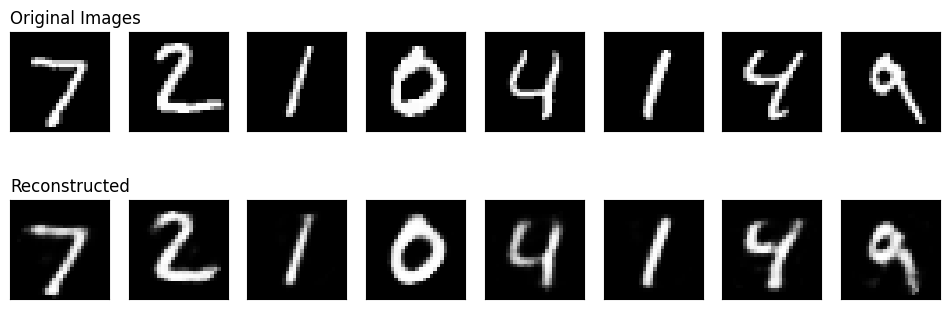

In [35]:
# 4) VISUALIZE: Show original vs. reconstructed images

import matplotlib.pyplot as plt

print("\nVisualizing model reconstructions...")
mnist_ae.eval()
with torch.no_grad():
    # Get a batch of test images
    dataiter = iter(mnist_test_loader)
    images, _ = next(dataiter)
    images = images.to(device)

    # Get reconstructed images from our autoencoder
    reconstructed_images = mnist_ae(images).cpu()

    # Plot the first 8 images and their reconstructions
    plt.figure(figsize=(12, 4))
    for i in range(8):
        # Display original images
        ax = plt.subplot(2, 8, i + 1)
        plt.imshow(images[i].cpu().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title("Original Images", loc='left')

        # Display reconstructed images
        ax = plt.subplot(2, 8, i + 1 + 8)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0: ax.set_title("Reconstructed", loc='left')
    plt.show()

## Transfer Learning

### Unsupervised Pre-training

GOAL: Now that we understand the basic concept of an autoencoder, we'll use a
more powerful CNN-based one on a harder dataset (CIFAR-10) and then use its
learned features for a new classification task.

In [36]:
# 1) DATA: CIFAR-10 (32x32 RGB)
tfm = transforms.Compose([
    transforms.ToTensor(),
])

trainset_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
testset_full  = datasets.CIFAR10(root="./data", train=False, download=True, transform=tfm)

# We'll keep training quick for the demo
train_loader_unsup = DataLoader(trainset_full, batch_size=128, shuffle=True, num_workers=2)
test_loader_unsup  = DataLoader(testset_full,  batch_size=128, shuffle=False, num_workers=2)

In [37]:
# 2) MODEL: Encoder-Decoder (Autoencoder)
#    Encoder has 3 conv blocks; we'll later reuse ONLY the first two blocks.
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: 3 -> 32
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32x32 -> 16x16
        )
        # Block 2: 32 -> 64
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16x16 -> 8x8
        )
        # Block 3: 64 -> 128
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 8x8 -> 4x4
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)  # shape: [B, 128, 4, 4]
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Mirror the encoder using conv-transpose
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),  # 4->8
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),   # 8->16
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 2, stride=2),   # 16->32
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, padding=1),            # back to 3 channels
            nn.Sigmoid()  # output in [0,1] to match ToTensor
        )

    def forward(self, z):
        z = self.up1(z)
        z = self.up2(z)
        z = self.up3(z)
        return z

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [38]:
# 3) Train the encoder (unsupervised) via reconstruction loss

ae = AutoEncoder().to(device)
opt_ae = optim.Adam(ae.parameters(), lr=1e-3)
recon_loss = nn.MSELoss()

def train_autoencoder(model, loader, epochs=3):
    model.train()
    for ep in range(epochs):
        t0 = time.time()
        running = 0.0
        for x, _ in loader:
            x = x.to(device)
            opt_ae.zero_grad(set_to_none=True)
            x_hat = model(x)
            loss = recon_loss(x_hat, x)
            loss.backward()
            opt_ae.step()
            running += loss.item()
        print(f"[AE] Epoch {ep+1}/{epochs} | recon={running/len(loader):.4f} | {time.time()-t0:.1f}s")

print(" Training autoencoder (to learn the encoder)...")
train_autoencoder(ae, train_loader_unsup, epochs=3)

 Training autoencoder (to learn the encoder)...
[AE] Epoch 1/3 | recon=0.0231 | 10.5s
[AE] Epoch 2/3 | recon=0.0136 | 10.4s
[AE] Epoch 3/3 | recon=0.0115 | 10.5s


In [39]:
# 4) Build a NEW classification task using ONLY the first
#    TWO blocks of the trained encoder (frozen).
#    Task: Binary 'vehicle' (0) vs 'animal' (1)

vehicle = {0,1,8,9}
animal  = {2,3,4,5,6,7}

def relabel_to_binary(targets):
    y = np.array(targets)
    y_bin = np.zeros_like(y)
    y_bin[np.isin(y, list(animal))] = 1
    return y_bin

train_targets_bin = relabel_to_binary(trainset_full.targets)
test_targets_bin  = relabel_to_binary(testset_full.targets)

# A clean wrapper that returns (image, binary_label) directly
from torch.utils.data import Dataset, DataLoader

class BinarySubset(Dataset):
    def __init__(self, base_ds, indices, labels_binary):
        self.base_ds = base_ds
        self.indices = indices.astype(np.int64)
        self.targets = torch.tensor(labels_binary, dtype=torch.long)
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, _ = self.base_ds[self.indices[i]]
        y = self.targets[i].item()
        return x, y

def build_binary_dataset(base_ds, y_bin, max_per_class=None):
    idx0 = np.where(y_bin == 0)[0]
    idx1 = np.where(y_bin == 1)[0]
    if max_per_class is not None:
        idx0 = idx0[:max_per_class]
        idx1 = idx1[:max_per_class]
    idx = np.concatenate([idx0, idx1])
    labels = y_bin[idx]
    return BinarySubset(base_ds, idx, labels)

train_ds_bin = build_binary_dataset(trainset_full, train_targets_bin, max_per_class=6000)
test_ds_bin  = build_binary_dataset(testset_full,  test_targets_bin,  max_per_class=1000)

train_loader_cls = DataLoader(train_ds_bin, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader_cls  = DataLoader(test_ds_bin,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)


In [40]:
# 5) Feature extractor = first two blocks of encoder (FROZEN)

frozen_feat = nn.Sequential(
    ae.encoder.block1,
    ae.encoder.block2
).to(device)

for p in frozen_feat.parameters():
    p.requires_grad = False

with torch.no_grad():
    sample = torch.randn(1,3,32,32).to(device)
    feat = frozen_feat(sample)            # [1, 64, 8, 8]
    feat_dim = feat.view(1, -1).size(1)

class Head(nn.Module):
    def __init__(self, in_dim, hidden=256, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(inplace=True),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, f):
        f = torch.flatten(f, 1)
        return self.net(f)

head = Head(in_dim=feat_dim, hidden=256, num_classes=2).to(device)

class FrozenTransfer(nn.Module):
    def __init__(self, feat, head):
        super().__init__()
        self.feat = feat
        self.head = head
    def forward(self, x):
        with torch.no_grad():
            f = self.feat(x)
        return self.head(f)

clf = FrozenTransfer(frozen_feat, head).to(device)

criterion = nn.CrossEntropyLoss()
opt_head = optim.Adam(head.parameters(), lr=1e-3)

def train_classifier(model, optimizer, loader, epochs=3):
    model.train()
    for ep in range(epochs):
        t0 = time.time()
        run = 0.0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            run += loss.item()
        print(f"[Head] Epoch {ep+1}/{epochs} | loss={run/len(loader):.4f} | {time.time()-t0:.1f}s")

def accuracy(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.numel()
    return correct / total

print("\n Phase A: Train ONLY a new classifier head on top of the frozen first-two-block encoder.")
train_classifier(clf, opt_head, train_loader_cls, epochs=3)
print(f"Validation accuracy (frozen features): {accuracy(clf, test_loader_cls)*100:.2f}%")



 Phase A: Train ONLY a new classifier head on top of the frozen first-two-block encoder.
[Head] Epoch 1/3 | loss=0.5055 | 1.9s
[Head] Epoch 2/3 | loss=0.3981 | 1.9s
[Head] Epoch 3/3 | loss=0.3545 | 1.8s
Validation accuracy (frozen features): 83.80%


In [41]:
# 6) OPTIONAL: Unfreeze the second block for a short fine-tune
for p in ae.encoder.block2.parameters():
    p.requires_grad = True

class PartiallyTrainable(nn.Module):
    def __init__(self, enc_block1, enc_block2, head):
        super().__init__()
        self.block1 = enc_block1    # stays frozen (we'll keep no_grad around it)
        self.block2 = enc_block2    # trainable
        self.head = head
    def forward(self, x):
        with torch.no_grad():
            x = self.block1(x)
        x = self.block2(x)
        x = torch.flatten(x, 1)
        return self.head.net(x)

pt_model = PartiallyTrainable(ae.encoder.block1, ae.encoder.block2, head).to(device)

opt_finetune = optim.Adam(
    list(ae.encoder.block2.parameters()) + list(head.parameters()),
    lr=3e-4
)

print("\n Phase B: Fine-tune with block2 + head trainable (block1 frozen).")
train_classifier(pt_model, opt_finetune, train_loader_cls, epochs=2)
print(f"Validation accuracy (after partial unfreeze): {accuracy(pt_model, test_loader_cls)*100:.2f}%")


 Phase B: Fine-tune with block2 + head trainable (block1 frozen).
[Head] Epoch 1/2 | loss=0.3117 | 2.0s
[Head] Epoch 2/2 | loss=0.2929 | 2.7s
Validation accuracy (after partial unfreeze): 87.05%


### Supervised Pre-training

GOAL: Provide the specific logic for the transfer learning task in the homework,
which uses a SUPERVISED pre-training task (rotation detection) rather than an unsupervised one.

In the demo above, we transferred knowledge from an unsupervised autoencoder.

The process is:
1.  Baseline: Train a CNN classifier for CIFAR-10 from scratch
2.  Pre-train: Train the same CNN architecture on a new, supervised task: predicting if an image is upright (label 0) or rotated 90 degrees (label 1)
3.  Transfer: Use the weights from the rotation model to initialize the CIFAR-10 model. Then, you'll compare the performance when you **freeze** the early layers vs. fine-tuning them.

In [42]:
# Snippet 1: How to create the rotation dataset

# NOTE: This is a standalone code snippet to demonstrate the logic.
# You would integrate this into a custom PyTorch Dataset class for the homework.
from torch.utils.data import TensorDataset

print("Logic for creating the rotation pre-training task data:")

# Get a sample batch from the original CIFAR-10 loader.
# We can use `train_loader_unsup` since we only need the images, not the labels.
sample_images, _ = next(iter(train_loader_unsup))

# Create original images with label 0 (upright)
labels_upright = torch.zeros(sample_images.size(0), dtype=torch.long)

# Create rotated images with label 1 (rotated)
# torch.rot90 rotates the planes specified by the `dims` argument.
# For a tensor of shape (B, C, H, W), the Height and Width dimensions are 2 and 3.
images_rotated = torch.rot90(sample_images, 1, [2, 3])
labels_rotated = torch.ones(sample_images.size(0), dtype=torch.long)

# Combine them to form the new dataset for the pre-training task
all_images = torch.cat([sample_images, images_rotated])
all_labels = torch.cat([labels_upright, labels_rotated])

# In your homework, you would then create a new Dataset and DataLoader with this data.
# For example: rotation_dataset = TensorDataset(all_images, all_labels)

print(f"Shape of original image batch: {sample_images.shape}")
print(f"Shape of rotated image batch:  {images_rotated.shape}")
print(f"Shape of combined batch for new task: {all_images.shape}")
print(f"Shape of combined labels for new task: {all_labels.shape}")

Logic for creating the rotation pre-training task data:
Shape of original image batch: torch.Size([128, 3, 32, 32])
Shape of rotated image batch:  torch.Size([128, 3, 32, 32])
Shape of combined batch for new task: torch.Size([256, 3, 32, 32])
Shape of combined labels for new task: torch.Size([256])


In [43]:
# Snippet 2: How to copy weights

# Assume you have:
# 1. `rotation_model`: A model with the same architecture, trained on the rotation task.
# 2. `target_model`: A fresh, randomly initialized model for CIFAR-10 classification.

# For this demo, we'll just use the trained autoencoder's encoder as a stand-in for the `rotation_model`.
# In your HW, you would load your saved rotation model weights.
# e.g., rotation_model.load_state_dict(torch.load('rotation_model_weights.pth'))
rotation_model_encoder = ae.encoder

# This is your fresh model for the main task. It must have the same layer names.
target_model_encoder = Encoder()

# Get the state dictionaries (a dictionary mapping layer names to weight tensors)
rotation_weights = rotation_model_encoder.state_dict()
target_weights = target_model_encoder.state_dict()

print("\n Logic for copying weights from pre-trained model to target model:")

# Iterate through the layers of the pre-trained model and copy weights
# to the target model if the layer name and shape match.
for layer_name in rotation_weights:
    if layer_name in target_weights:
        # This check is important if the models aren't identical (e.g., different final layers)
        if rotation_weights[layer_name].shape == target_weights[layer_name].shape:
            target_weights[layer_name] = rotation_weights[layer_name]
            print(f"  - Copied weights for layer: {layer_name}")

# Load the updated state dict into the target model
target_model_encoder.load_state_dict(target_weights)
print("Successfully transferred weights to the target model's encoder.")


 Logic for copying weights from pre-trained model to target model:
  - Copied weights for layer: block1.0.weight
  - Copied weights for layer: block1.0.bias
  - Copied weights for layer: block1.2.weight
  - Copied weights for layer: block1.2.bias
  - Copied weights for layer: block2.0.weight
  - Copied weights for layer: block2.0.bias
  - Copied weights for layer: block2.2.weight
  - Copied weights for layer: block2.2.bias
  - Copied weights for layer: block3.0.weight
  - Copied weights for layer: block3.0.bias
  - Copied weights for layer: block3.2.weight
  - Copied weights for layer: block3.2.bias
Successfully transferred weights to the target model's encoder.


**Reminder on Freezing vs. Fine-tuning**

Once you have copied the weights into your target_model, Problem 5 asks you to compare freezing vs. fine-tuning.

- To Freeze Layers: You can use the same `param.requires_grad = False` logic that we used in Phase A of the demo above.
- To Fine-tune: You simply train the entire model, ensuring all parameters have `requires_grad = True` (which is the default).

You can now apply the training and evaluation logic from the previous sections to complete the homework assignment.

## Contrastive Learning

GOAL: Implement a full contrastive learning pipeline. We will train a network not to classify, but to embed similar images close together and dissimilar images far apart in a 2D space.

In [44]:
# 1) MODEL: A simple CNN to produce 2D embeddings

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=2):
        super().__init__()
        # Use the encoder structure from the previous demo as a feature extractor
        # In a real scenario, you might use a standard architecture like ResNet
        self.feature_extractor = Encoder() # Re-using the CNN from Part 2

        # Get the output dimension from the feature extractor
        with torch.no_grad():
            sample_output = self.feature_extractor(torch.randn(1, 3, 32, 32))
            flattened_dim = sample_output.view(1, -1).size(1)

        # Projection head maps features to the desired embedding dimension
        self.projection_head = nn.Sequential(
            nn.Linear(flattened_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = torch.flatten(features, 1)
        embedding = self.projection_head(features)
        return embedding

In [45]:
# 2) DATA: A custom Dataset to provide pairs of images

class ContrastiveCIFAR10(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = np.array(self.base_dataset.targets)

        # Pre-compute a dictionary mapping each class to a list of its indices
        self.labels_to_indices = {label: np.where(self.labels == label)[0]
                                  for label in set(self.labels)}

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        # Get the anchor image and its label
        img1, label1 = self.base_dataset[index]

        # Decide whether to sample a positive or negative pair (50% chance)
        is_similar = random.random() > 0.5

        if is_similar:
            # Positive pair: sample another image from the same class
            positive_indices = self.labels_to_indices[label1]
            # Make sure we don't pick the same image
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(positive_indices)
            img2, _ = self.base_dataset[positive_index]
            similarity = 1.0 # Similarity label is 1 for positive pairs
        else:
            # Negative pair: sample an image from a different class
            negative_label = np.random.choice(list(set(self.labels) - {label1}))
            negative_indices = self.labels_to_indices[negative_label]
            negative_index = np.random.choice(negative_indices)
            img2, _ = self.base_dataset[negative_index]
            similarity = 0.0 # Similarity label is 0 for negative pairs

        return img1, img2, torch.tensor(similarity, dtype=torch.float32)

# Use the full CIFAR10 trainset from earlier
contrastive_train_ds = ContrastiveCIFAR10(trainset_full)
contrastive_train_loader = DataLoader(contrastive_train_ds, batch_size=64, shuffle=True, num_workers=2)

In [46]:
# 3) LOSS FUNCTION: Implement the contrastive loss from the homework

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, similarity_label):
        # Calculate the euclidean distance squared between the embeddings
        euclidean_distance = F.pairwise_distance(embedding1, embedding2, keepdim=True)
        dist_sq = torch.pow(euclidean_distance, 2)

        # Loss for similar pairs (S=1): we want their distance to be small
        loss_similar = similarity_label * dist_sq

        # Loss for dissimilar pairs (S=0): we want their distance to be large, at least > margin
        # The loss is max(0, margin - distance)^2
        loss_dissimilar = (1 - similarity_label) * torch.pow(
            torch.clamp(self.margin - euclidean_distance, min=0.0), 2
        )

        # Combine the losses and average over the batch
        total_loss = torch.mean(loss_similar + loss_dissimilar)
        return total_loss

Visualizing embeddings of the UNTRAINED model...


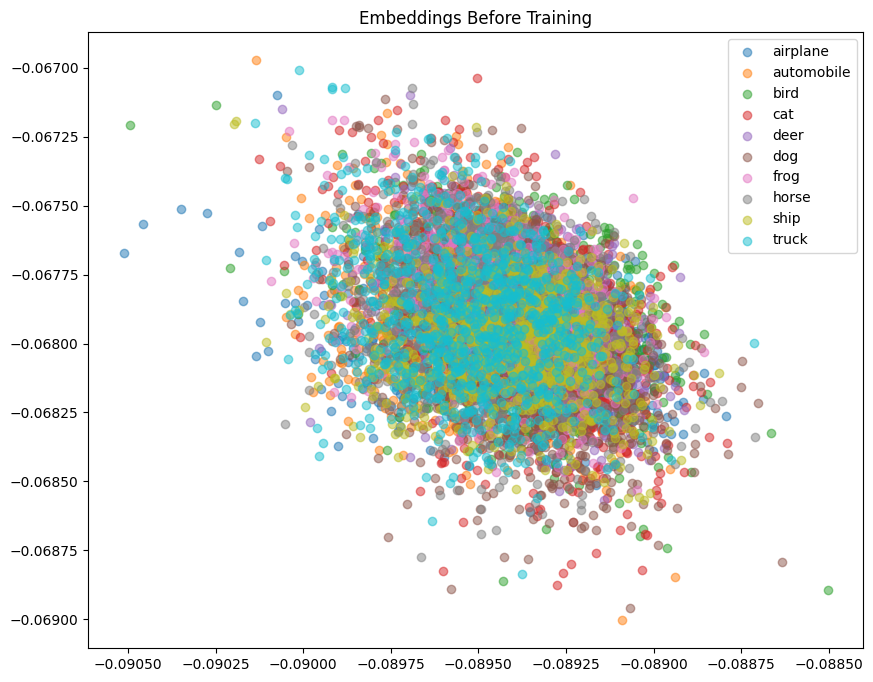


Training the embedding network with contrastive loss...
[Contrastive] Epoch 1/3 | Loss=0.3049 | 131.9s
[Contrastive] Epoch 2/3 | Loss=0.2994 | 126.3s
[Contrastive] Epoch 3/3 | Loss=0.2974 | 125.4s

Visualizing embeddings of the TRAINED model...


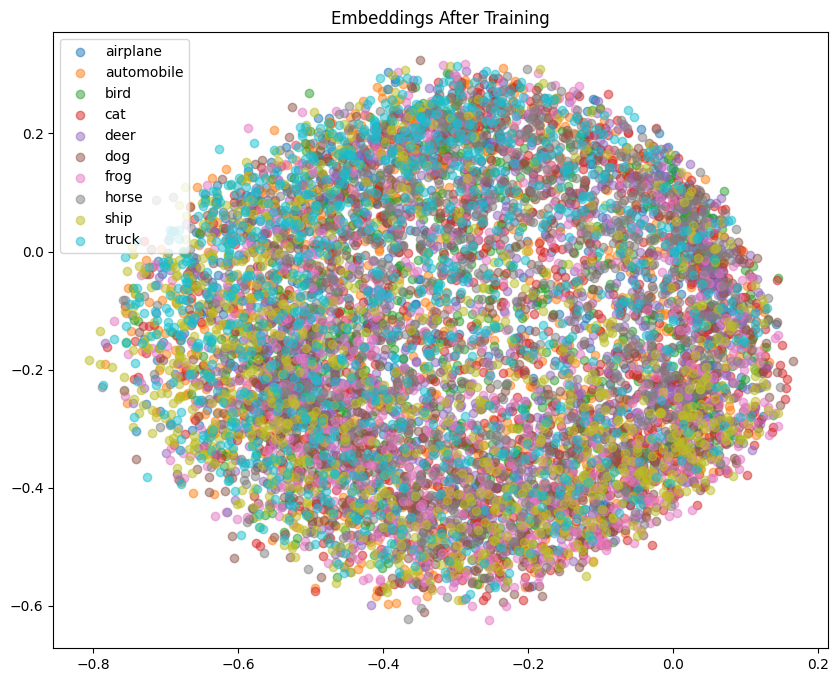

In [47]:
# 4) VISUALIZATION and TRAINING SCRIPT

import matplotlib.pyplot as plt

# Helper function to get all embeddings for a dataset
def get_all_embeddings(model, loader):
    model.eval()
    embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            embs = model(images).cpu().numpy()
            embeddings.append(embs)
            all_labels.append(labels.numpy())
    return np.concatenate(embeddings), np.concatenate(all_labels)

# Helper function to plot the embeddings
def plot_embeddings(embeddings, labels, title=""):
    plt.figure(figsize=(10, 8))
    class_names = trainset_full.classes
    for i in range(len(class_names)):
        # Select embeddings that correspond to the current class
        inds = np.where(labels == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, label=class_names[i])
    plt.title(title)
    plt.legend()
    plt.show()

# Main Script
# 1. Instantiate the model, loss, and optimizer
embedding_net = EmbeddingNet(embedding_dim=2).to(device)
contrastive_loss_fn = ContrastiveLoss(margin=1.0)
opt_contrastive = optim.Adam(embedding_net.parameters(), lr=5e-4)

# Use the standard test loader for visualization
test_loader_vis = DataLoader(testset_full, batch_size=256, shuffle=False)

# 2. Visualize embeddings BEFORE training
print("Visualizing embeddings of the UNTRAINED model...")
initial_embeddings, initial_labels = get_all_embeddings(embedding_net, test_loader_vis)
plot_embeddings(initial_embeddings, initial_labels, "Embeddings Before Training")

# 3. Train the model
print("\nTraining the embedding network with contrastive loss...")
embedding_net.train()
for ep in range(3): # Train for 3 epochs for the demo
    t0 = time.time()
    running_loss = 0.0
    for img1, img2, sim in contrastive_train_loader:
        img1, img2, sim = img1.to(device), img2.to(device), sim.to(device)

        opt_contrastive.zero_grad()
        emb1, emb2 = embedding_net(img1), embedding_net(img2)
        loss = contrastive_loss_fn(emb1, emb2, sim)
        loss.backward()
        opt_contrastive.step()
        running_loss += loss.item()
    print(f"[Contrastive] Epoch {ep+1}/3 | Loss={running_loss/len(contrastive_train_loader):.4f} | {time.time()-t0:.1f}s")

# 4. Visualize embeddings AFTER training
print("\nVisualizing embeddings of the TRAINED model...")
final_embeddings, final_labels = get_all_embeddings(embedding_net, test_loader_vis)
plot_embeddings(final_embeddings, final_labels, "Embeddings After Training")